# Zero-shot image classification

Training a CNN to classify images is a time-consuming proposition. Even with transfer learning to help out, you still have to collect images representing each class (the more, the better, and the more diverse, the better, too), choose a base model, and train a classifier on features extracted by the base model. What if someone told you that state-of-the-art image classification can be accomplished without training a model or collecting even a single training image? Furthermore, what if images classified this way aren't constrained to the 1,000 ImageNet classes, but can be classified in hundreds of thousands of ways?

That's zero-shot image classification in a nutshell. It relies on [Contrastive Language-Image Pretraining](https://openai.com/research/clip) (CLIP) models, which are trained to correlate images and textual descriptions of the same images. OpenAI developed CLIP and open-sourced it after training it on approximately 400 million image-text pairs. Pretrained CLIP implementations are now available from Hugging Face and from other sources.

![](Images/clip.png)

Let's use a CLIP model from Hugging Face to implement zero-shot image classification and see first-hand how it works. Start by loading the model from Hugging Face's [transformers](https://pypi.org/project/transformers/) package. [`clip-vit-large-patch14`](https://huggingface.co/openai/clip-vit-large-patch14) combines a vision transformer (ViT) that produces an embedding from an image with a text transformer that decodes the embedding into a caption such as "a photo of a parrot:" 

In [1]:
from transformers import pipeline

model = pipeline(
    model='openai/clip-vit-large-patch14',
    task='zero-shot-image-classification'
)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor confi

Next, define helper functions for loading images from the file system and assigning class labels and for displaying image collections. Then declare a pair of lists to store images (`x`) and labels (`y`):

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images, labels = [], []

    for file in os.listdir(path):
        image = Image.open(os.path.join(path, file))
        images.append(image)
        labels.append(label)

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(images[i]) / 255)

x, y = [], []

Load 10 Arctic-fox images from the "arctic_fox" subdirectory and label them with 0s:

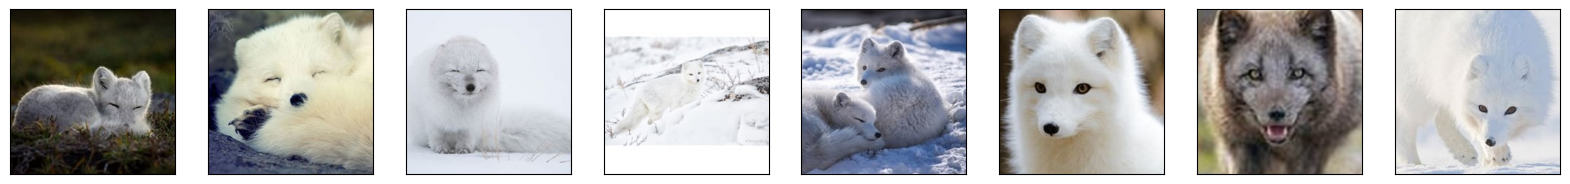

In [3]:
images, labels = load_images_from_path('Wildlife/arctic_fox', 0)
show_images(images)

x += images
y += labels

Load 10 polar-bear images and label them with 1s:

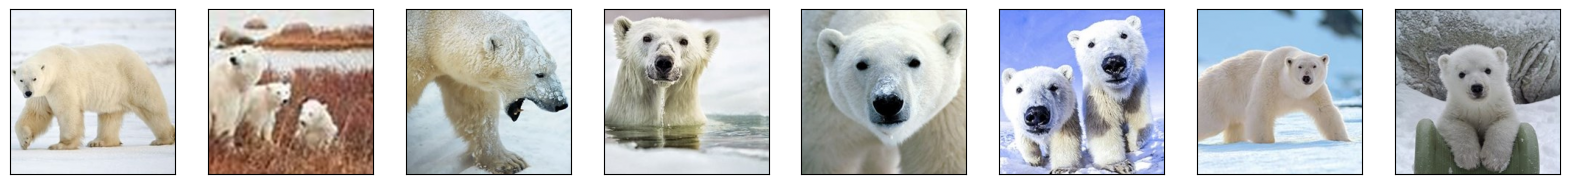

In [4]:
images, labels = load_images_from_path('Wildlife/polar_bear', 1)
show_images(images)

x += images
y += labels

Finally, load 10 walrus images and label them with 2s:

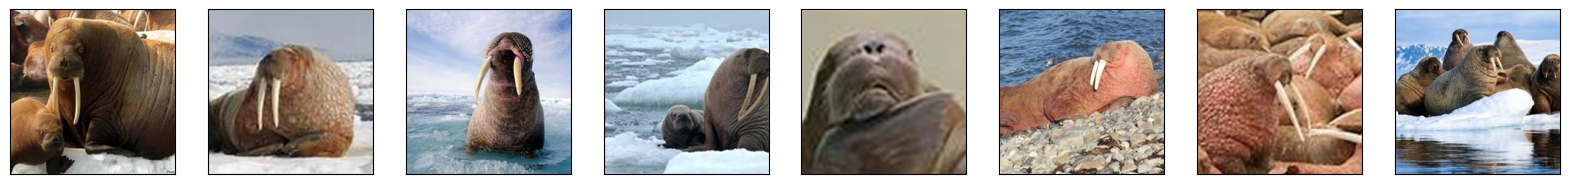

In [5]:
images, labels = load_images_from_path('Wildlife/walrus', 2)
show_images(images)

x += images
y += labels

Submit all 30 images to the model and use CLIP to predict a class for each:

In [6]:
y_pred = []
class_labels = ['arctic fox', 'polar bear', 'walrus']

for i in range(len(x)):
    result = model(x[i], candidate_labels=class_labels)
    predicted_class = class_labels.index(result[0]['label'])
    score = result[0]['score']
    print(f'{class_labels[y[i]]} -> {class_labels[predicted_class]} ({score:.1%})')
    y_pred.append(predicted_class)

arctic fox -> arctic fox (100.0%)
arctic fox -> arctic fox (99.9%)
arctic fox -> arctic fox (100.0%)
arctic fox -> arctic fox (100.0%)
arctic fox -> arctic fox (99.9%)
arctic fox -> arctic fox (100.0%)
arctic fox -> arctic fox (100.0%)
arctic fox -> arctic fox (99.9%)
arctic fox -> arctic fox (100.0%)
arctic fox -> arctic fox (100.0%)
polar bear -> polar bear (99.9%)
polar bear -> polar bear (98.5%)
polar bear -> polar bear (99.7%)
polar bear -> polar bear (99.9%)
polar bear -> polar bear (99.9%)
polar bear -> polar bear (99.9%)
polar bear -> polar bear (99.9%)
polar bear -> polar bear (99.8%)
polar bear -> polar bear (99.6%)
polar bear -> polar bear (100.0%)
walrus -> walrus (100.0%)
walrus -> walrus (100.0%)
walrus -> walrus (100.0%)
walrus -> walrus (99.9%)
walrus -> walrus (99.9%)
walrus -> walrus (100.0%)
walrus -> walrus (100.0%)
walrus -> walrus (100.0%)
walrus -> walrus (99.9%)
walrus -> walrus (100.0%)


Use a confusion matrix to assess the model's performance:

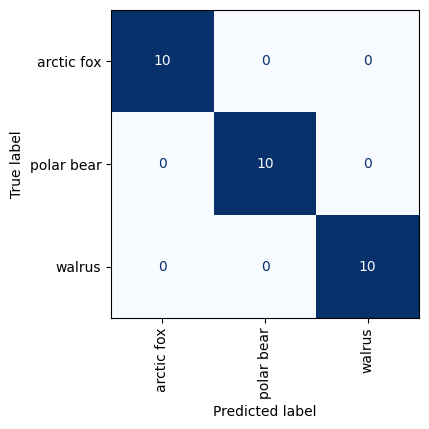

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(False)

cmd.from_predictions(y, y_pred,
                     display_labels=class_labels, colorbar=False,
                     cmap='Blues', xticks_rotation='vertical', ax=ax)

Zero-shot image classification doesn't mean that there will never be a need to train a CNN of your own. When training involves teaching a model to differentiate between audio spectrogram images, for example, transfer learning is still your best option. But when it comes to classifying images containing everyday objects, zero-shot learning might be the best tool for the job.